In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

In [4]:
# Load data downloaded from gridstatus.io
load_data = pd.read_csv('data/CAISO_Load.csv', index_col=0)
price_data_2022 = pd.read_csv('data/CAISO_RTP_2022.csv', index_col=0)

/var/folders/f2/rxpbf6rd2wjbpqry4k3rs6fr0000gn/T/ipykernel_55539/3633684683.py:2: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  load_data = pd.read_csv('data/CAISO_Load.csv', index_col=0)


In [6]:
# Identify numeric columns
numeric_cols = load_data.select_dtypes(include='number').columns

# Interpolate numeric columns
load_data[numeric_cols] = load_data[numeric_cols].interpolate(method='linear', limit_direction='both')


In [7]:
# Determine the number of rows corresponding to each year
rows_2022 = 105120  # 5-minute intervals in a non-leap year (365 * 24 * 12)

# Separate the data into 2022 and 2023 based on the number of rows
load_data_2022 = load_data.iloc[:rows_2022]
load_data_2023 = load_data.iloc[rows_2022:].reset_index(drop=True)

# Save the separated data into two CSV files
load_data_2022.to_csv('data/CAISO_Load_2022.csv')
load_data_2023.to_csv('data/CAISO_Load_2023.csv')

# Check for NA values in the price data, no NA values in the price data
na_counts = price_data_2022.isna().sum()
print(na_counts)



interval_start_local    0
interval_end_local      0
market                  0
location                0
location_type           0
lmp                     0
energy                  0
congestion              0
loss                    0
dtype: int64


In [8]:
# Merge the load and price data on the interval start time
merged_data = pd.merge(load_data_2022, price_data_2022, on='interval_start_local', suffixes=('_load', '_price'))

# Check for positive correlation between net_load and lmp
correlation = (merged_data['net_load']).corr(merged_data['energy'])

print(f"Correlation between net_load and energy price: {correlation}")


Correlation between net_load and energy price: 0.37165486011553855


In [9]:
# Define the number of bins for the piecewise function
n_bins = 500

# Fit the KBinsDiscretizer using quantile strategy
kb = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
net_load_binned = kb.fit_transform(merged_data[['net_load']])

# Create a DataFrame to store the binned net load and the corresponding mean energy price
binned_data = pd.DataFrame({
    'net_load_bin': net_load_binned.flatten(),
    'energy_price': merged_data['energy']
})

# Calculate the mean energy price for each bin
binned_data_grouped = binned_data.groupby('net_load_bin').mean().reset_index()

# Map the bin number back to the corresponding net load range
bin_edges = kb.bin_edges_[0]
binned_data_grouped['net_load'] = bin_edges[1:]

# Ensure the function is monotonic increasing by applying a cumulative maximum
binned_data_grouped['energy_price'] = binned_data_grouped['energy_price'].cummax()

# Calculate the capacity for each segment as the difference between consecutive net load values
binned_data_grouped['capacity_MW'] = binned_data_grouped['net_load'].diff().fillna(binned_data_grouped['net_load'])

# Adjust the last segment to ensure the total capacity matches the maximum net load
total_capacity = binned_data_grouped['capacity_MW'].sum()
excess_capacity = total_capacity - merged_data['net_load'].max()

# Subtract excess capacity from the last segment
binned_data_grouped['capacity_MW'].iloc[-1] -= excess_capacity

# Verify that the total capacity sums up to the maximum net load
total_capacity = binned_data_grouped['capacity_MW'].sum()
print(f"Total Capacity: {total_capacity}")

# Ensure the total capacity equals the maximum net load
if np.isclose(total_capacity, merged_data['net_load'].max()):
    print("Total capacity matches the maximum net load.")
else:
    print("Discrepancy in total capacity calculation.")

Total Capacity: 45379.0
Total capacity matches the maximum net load.


In [10]:
# Adjust the custom bin edges calculation and mapping to ensure proper length
# Define the number of bins for the piecewise function
n_bins = 500
additional_bins = 200  # Additional bins for the top 2% net load

# Calculate the threshold for the top 2% net load
top_2_percentile = merged_data['net_load'].quantile(0.98)

# Create custom bin edges with more bins for the top 2% net load
custom_bin_edges = np.concatenate([
    np.linspace(merged_data['net_load'].min(), top_2_percentile, n_bins - additional_bins, endpoint=False),
    np.linspace(top_2_percentile, merged_data['net_load'].max(), additional_bins + 1)
])

# Fit the KBinsDiscretizer using the custom bin edges
kb = KBinsDiscretizer(n_bins=len(custom_bin_edges) - 1, encode='ordinal', strategy='uniform')
net_load_binned = kb.fit_transform(merged_data[['net_load']])

# Create a DataFrame to store the binned net load and the corresponding mean energy price
binned_data = pd.DataFrame({
    'net_load_bin': net_load_binned.flatten(),
    'energy_price': merged_data['energy']
})

# Calculate the mean energy price for each bin
binned_data_grouped = binned_data.groupby('net_load_bin').mean().reset_index()

# Map the bin number back to the corresponding net load range
binned_data_grouped['net_load'] = custom_bin_edges[1:len(binned_data_grouped) + 1]

# Ensure the function is monotonic increasing by applying a cumulative maximum
binned_data_grouped['energy_price'] = binned_data_grouped['energy_price'].cummax()

# Calculate the capacity for each segment as the difference between consecutive net load values
binned_data_grouped['capacity_MW'] = binned_data_grouped['net_load'].diff().fillna(binned_data_grouped['net_load'])

# Adjust the last segment to ensure the total capacity matches the maximum net load
total_capacity = binned_data_grouped['capacity_MW'].sum()
excess_capacity = total_capacity - merged_data['net_load'].max()
binned_data_grouped['capacity_MW'].iloc[-1] -= excess_capacity

# Verify that the total capacity sums up to the maximum net load
total_capacity = binned_data_grouped['capacity_MW'].sum()
print(f"Total Capacity: {total_capacity}")

# Ensure the total capacity equals the maximum net load
if np.isclose(total_capacity, merged_data['net_load'].max()):
    print("Total capacity matches the maximum net load.")
else:
    print("Discrepancy in total capacity calculation.")

# Save capacity_MW and energy_price to a new DataFrame for the thermal generator offer curve
thermal_generator_offer_curve = binned_data_grouped[['capacity_MW', 'energy_price']].copy()

Total Capacity: 45379.0
Total capacity matches the maximum net load.


In [11]:
# Save capacity_MW and energy_price to a new DataFrame for the thermal generator offer curve
thermal_generator_offer_curve = binned_data_grouped[['capacity_MW', 'energy_price']].copy()
# Merge segments with identical prices and sum their capacities
merged_curve = thermal_generator_offer_curve.groupby('energy_price', as_index=False).agg({
    'capacity_MW': 'sum'
})
merged_curve.to_csv('data/thermal_gen_offer.csv')

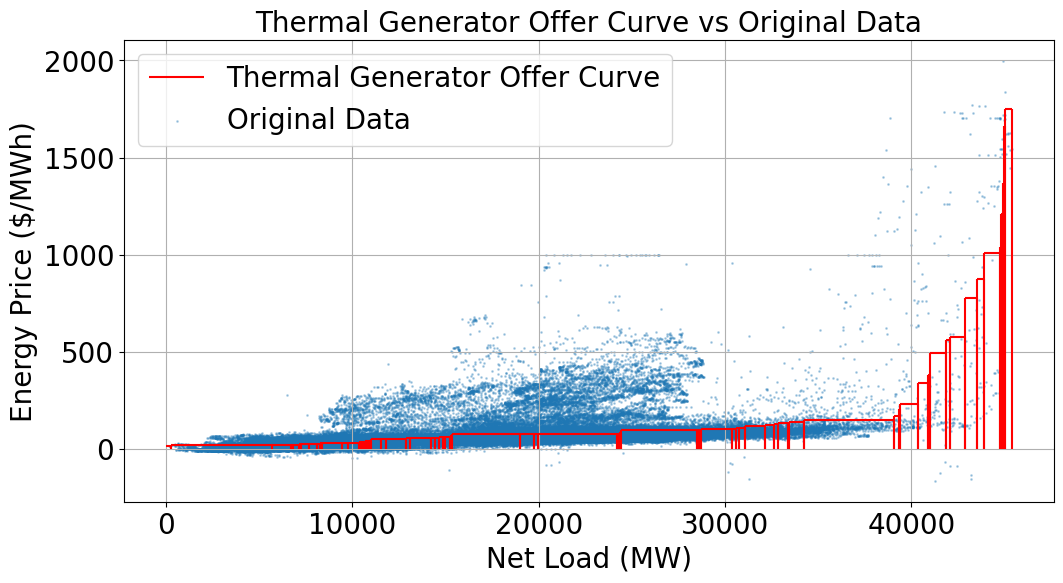

In [15]:
# Calculate the cumulative capacity for merged segments
merged_curve['cumulative_capacity_MW'] = merged_curve['capacity_MW'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
for i in range(len(merged_curve)):
    if i == 0:
        plt.hlines(merged_curve['energy_price'].iloc[i], 0, merged_curve['cumulative_capacity_MW'].iloc[i], colors='red', label='Thermal Generator Offer Curve')
        plt.vlines(merged_curve['cumulative_capacity_MW'].iloc[i], 0, merged_curve['energy_price'].iloc[i], colors='red')
    else:
        plt.hlines(merged_curve['energy_price'].iloc[i], merged_curve['cumulative_capacity_MW'].iloc[i-1], merged_curve['cumulative_capacity_MW'].iloc[i], colors='red')
        plt.vlines(merged_curve['cumulative_capacity_MW'].iloc[i-1], 0, merged_curve['energy_price'].iloc[i], colors='red')
        plt.vlines(merged_curve['cumulative_capacity_MW'].iloc[i], 0, merged_curve['energy_price'].iloc[i], colors='red')
plt.scatter(merged_data['net_load'], merged_data['energy'], label='Original Data', alpha=0.3, s=1)
plt.xlabel('Net Load (MW)', fontsize = 20)
plt.ylabel('Energy Price ($/MWh)', fontsize = 20)
plt.title('Thermal Generator Offer Curve vs Original Data', fontsize = 20)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.grid(True)
plt.show()